### Prophylactic Efficacy Predictor Vectorized (PEPV)

This package is used to compute the prophylactic efficacy in vectorized way 
such that the computation can be performed for multiple individuals and dosing schemes 
simultaneously. Currently, it is applicable on DTG, TDF, FTC and Truvada (combination of DTG and FTC). To use this package following python packages are neede: torch, pandas, numpy.

Interface of this program is the Class EfficacyPredictor. All functions can be called by an object of this class. To run the computation for a certain regimen, we need to generate an object of Class Regimen by giving the related information about the regimen. Then this Regimen object will be added to the EfficacyPredictor object for the computation of extinction probability / efficacy. 

The following code shows an examplary application of this package for the male population:

In [1]:
#!pip install torch
from PEPV import *       # import this package
from utils_avg_extinction_men import * 
import torch             # import the necessary python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\malin\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


#### Example 1: compute the extinction probability/efficacy for one single drug
All methods are called using the interface class EfficacyPredictor, i.e. first an object of EfficacyPredictor should be generated. 
For each different regimen, an object of class Regimen should be generated, initial arguments for Regimen are: 
1. drug: abbr. of the drug, ('DTG', 'TDF' or 'FTC') 
2. period: period of each dose in hour (e.g. 24 means that pill is taken every 24 hours)
3. time_span: tuple: beginning and end time of this regimen in hour. 0 denotes always the beginning of the first dose, i.e. negative value denotes the time before the first dose is taken. The values of both side should be integer multiple of the period, e.g. if period=24, the time_span should be (i*24, j*24) for i, j are integers. 
4. dose: dosing of the drug in mg, for example 'TDF' dose=300
5. n_doses: doses that should be taken, for example: in a once-daily regimen n_doses=30 (but in computation the actual number of doses may be smaller than 30 because of the adherence)
6. adh_level: adherence level, all n_doses will be taken if adh_level=1; if adh_level<1, random pattern will be generated based on n_doses and adh_level
7. adh_pattern: default parameter, is None by default, can be given if we need a certain pattern of adherence, this pattern should be a 2-D np array or list with 0 and positive integers (usually 0 and 1, denoting how many pills are taken on the corresponding day, can also be greater than 1). It's 2D because the program also supports computing more than one pattern in a run. Example: if the drug is taken every second day: 'adh_pattern= [[1, 0, 1, 0, 1, 0]]'; for two drug taking patterns, once daily and once every second day, the pattern can be: 'adh_pattern=[[1, 1, 1, 1], [1, 0, 1, 0]]'. The first digit in the pattern represents the dosing on the first day, i.e. at time=0 of the time_span. **Important**: if adh_pattern is given, n_doses and adh_level will not be used to generate the adherence pattern, but we still need to input some numbers for the positional arguments. The length of the adh_pattern can be different from time_span, but time_span will be used as standard for the computation: if time_span[0]<0, additional 0 will be added to the beginning of adh_pattern; if time_span[1] > the length of pattern, 0 will also be added to the end of pattern.    

After adding the Regimen object to the EfficacyPredictor object, we can compute the extinction probability or efficacy by calling the corresponding functions. 

In [2]:
t0, t1 = -48, 20*24 # convert 22 days to hours
# dosing pattern starting from the first dose, i.e. t=0 (t<0 is therefore not included in the pattern)
p = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)

# create an instance of efficacy predictor
e = EfficacyPredictor()
e.add_regimen(r)
e.add_regimen(r1)

# compute extinction probability for combination of FTC and TFV
e.compute_extinction_probability()
pe = e.get_extinction_probability()
print(pe.shape)
#print(pe)

e.compute_efficacy()
phi = e.get_efficacy()
print(phi.shape)
#print(phi)

e.compute_infection_probability()
pi = e.get_infection_probability()
print(pi.shape)
print(pi)


A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 
torch.Size([26401, 1, 1, 3, 1])
torch.Size([26401, 1, 1])
PGS class changed
torch.Size([26401, 1, 1, 3, 1])
tensor([[[[[9.0695e-02],
           [4.4885e-01],
           [9.8379e-01]]]],



        [[[[9.0690e-02],
           [4.4883e-01],
           [9.8379e-01]]]],



        [[[[9.0686e-02],
           [4.4881e-01],
           [9.8379e-01]]]],



        ...,



        [[[[3.3826e-13],
           [4.6653e-09],
           [0.0000e+00]]]],



        [[[[0.0000e+00],
           [2.3333e-09],
           [0.0000e+00]]]],



        [[[[0.0000e+00],
           [0.0000e+00],
           [0.0000e+00]]]]], dtype=torch.float64)


tensor([0.0616, 0.0617, 0.0617,  ..., 0.9956, 0.9956, 0.9956],
       dtype=torch.float64)


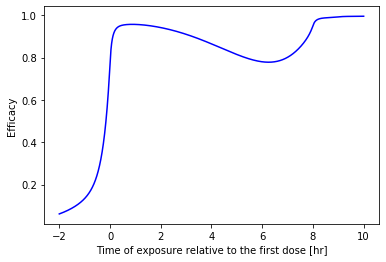

In [16]:
# we can see that the extra 2 days before the first dose were also computed correctly
# print([t/24/50 for t in range(-48*50, 10*24*50)])
t = [t/24/50 for t in range(-48*50, 10*24*50)]
plt.plot(t, phi[:14400,0,0], color = 'b')
print(phi[:14400,0,0])
plt.xlabel('Time of exposure relative to the first dose [hr]')
plt.ylabel('Efficacy')
plt.show()



tensor([0.9078, 0.9078, 0.9078,  ..., 0.9996, 0.9996, 0.9996],
       dtype=torch.float64)
tensor([9.0695e-02, 9.0690e-02, 9.0686e-02,  ..., 4.9430e-07, 4.9392e-07,
        4.9353e-07], dtype=torch.float64)


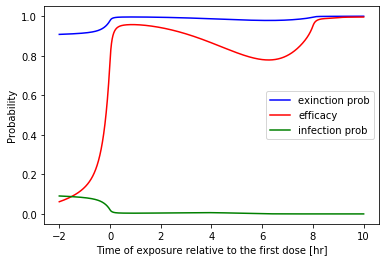

In [15]:
plt.plot(t, pe[:14400,0,0,0,0], label = 'exinction prob', color = 'b')
plt.plot(t, phi[:14400,0,0], label = 'efficacy', color = 'r')
plt.plot(t, pi[:14400,0,0,0,0],label = 'infection prob', color = 'g')
plt.xlabel('Time of exposure relative to the first dose [hr]')
plt.ylabel('Probability')
plt.legend()
print(pe[:14400,0,0,0,0])
print(pi[:14400,0,0,0,0])
plt.show()


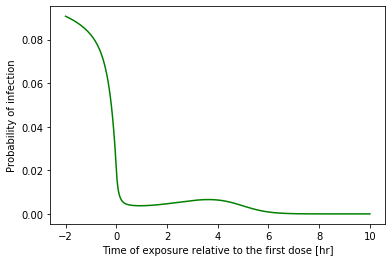

In [13]:
plt.plot(t, pi[:14400,0,0,0,0], color = 'g')
plt.xlabel('Time of exposure relative to the first dose [hr]')
plt.ylabel('Probability of infection')
plt.show()


A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 
torch.Size([26401, 1, 1, 3, 1])
torch.Size([26401, 1, 1])
PGS class changed
torch.Size([26401, 1, 1, 3, 1])


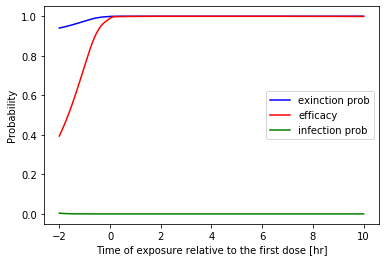

In [18]:
t0, t1 = -48, 20*24 # convert 22 days to hours
# dosing pattern starting from the first dose, i.e. t=0 (t<0 is therefore not included in the pattern)
p = np.array([[1,1,1,1,1,1,1,1,1,1,1,1,1,1]])
r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)

# create an instance of efficacy predictor
e = EfficacyPredictor()
e.add_regimen(r)
e.add_regimen(r1)

# compute extinction probability for combination of FTC and TFV
e.compute_extinction_probability()
pe = e.get_extinction_probability()
print(pe.shape)
#print(pe)

e.compute_efficacy()
phi = e.get_efficacy()
print(phi.shape)
#print(phi)

e.compute_infection_probability()
pi = e.get_infection_probability()
print(pi.shape)


plt.plot(t, pe[:14400,0,0,0,0], label = 'exinction prob', color = 'b')
plt.plot(t, phi[:14400,0,0], label = 'efficacy', color = 'r')
plt.plot(t, pi[:14400,0,0,0,0],label = 'infection prob', color = 'g')
plt.xlabel('Time of exposure relative to the first dose [hr]')
plt.ylabel('Probability')
plt.legend()

For Truvada we can also run the computation for multiple individuals, but we have to input the files of PK parameters for TDF and FTC seperately. 


**Attention (1)**
For this project, we will be looking at the trials in men. We only have the average pharmacokinetic parameters. Hence, we are simulating one trajectory.
No files have to be added (as shown below), as the programm will use the parameters by default.
 
See lines 153-159 in pk.py: when commenting out those lines of code, we directly use the NRTI PK model from PMID: 27439573. Otherwise, we would be using the PK model for the female population. 



### This program also has some other small functions:

a) compute or get the drug concentration

b) change the file of MMOA for Truvada

c) change the local-to-PBMC level 

We will start with a general example, and then move into each of the above specified functions.

In [36]:
# First, I set-up my simulation parameters:
# in this example, I will run a simulation for 2 weeks
weeks = 2
days = weeks*7
t0, t1 = 0, days*24

 #I specify a weekly regimen and compute my adherence pattern
weekly_adherence = [1,1,1,1,1,1,1] # one dose everyday
p = np.array([weekly_adherence*weeks])
print(p)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


In [37]:
# I can now run the simulation and compute the extinction probability:
# for Truvada in the male population
r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)
e = EfficacyPredictor()
e.add_regimen(r)
e.add_regimen(r1)
e.compute_extinction_probability()
pe = e.get_extinction_probability()
print(pe.shape)

# Here, I compute the efficacy considering the viral exposure comes from 100% anal intercourse
# I have added a position for the indicator, and lines 82-84 in process_pe_to_phi() (in utils_avg_extinction_men.py)
indicator = [0,0,0,0,1] 
phi_rai = process_pe_to_phi(indicator, [pe.numpy()])
print(phi_rai.shape)

#phi2.shape
# shape is (t, N_trajectories, 1, 3, 1)
# we have only mean values for men, hence we have only 1 trajectory of length t

A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 
torch.Size([16801, 1, 1, 3, 1])
(16801, 1, 1, 3, 1)
(16801, 1, 1, 3, 1)


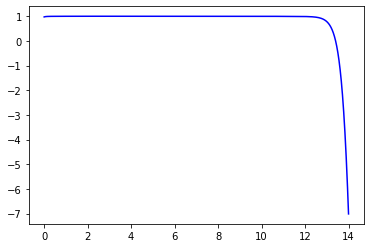

In [5]:
full_traj = days*24*50
plt.plot([t/24/50 for t in range(full_traj)], phi_rai[:full_traj,:,0,0,0], color = 'blue')
plt.show()

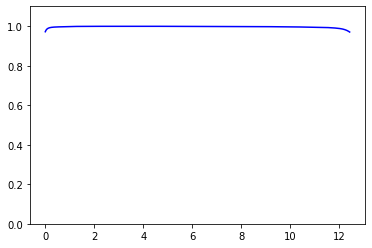

In [6]:
remove_tail = (days*24*50)-(38*50) #removing the last 38 hours from the trajectory
plt.plot([t/24/50 for t in range(remove_tail)], phi_rai[:remove_tail,:,0,0,0], color = 'blue')
plt.ylim(0,1.1)
plt.show()

### a) compute or get the drug concentration



In [38]:
# a) we can get concentration of a drug after computing the extinction probability:

# use the getter function to get the concentration of the given drug
c_tdf = e.get_concentration('TDF')
c_ftc = e.get_concentration('FTC')

c_tdf.shape, c_ftc.shape
# The first 3 dimentions of the concentration matrix have the same meaning as explained above. 
# The last dimension correspond to the compartments in the PK model. 
# Do a to check print(c_tdf.shape)
# the 4 compartments occur in the following order for our PK model in men:
# (C1, C2, C3, D): central, peripheral, cellular (PBMC) and dosing compartment.


(torch.Size([16801, 1, 1, 4]), torch.Size([16801, 1, 1, 4]))

In [47]:
e.compute_drug_effect()
eta = e.get_drug_effect()
print(eta)

(tensor([[[0.0000]],

        [[0.0000]],

        [[0.0028]],

        ...,

        [[0.9936]],

        [[0.9936]],

        [[0.9936]]], dtype=torch.float64), {1: tensor([[[0.1292]],

        [[0.1292]],

        [[0.1293]],

        ...,

        [[0.1623]],

        [[0.1623]],

        [[0.1623]]], dtype=torch.float64), 2: 0.015416666666666667, 3: 0.041666666666666664, 4: tensor([[[0.0333]],

        [[0.0333]],

        [[0.0332]],

        ...,

        [[0.0002]],

        [[0.0002]],

        [[0.0002]]], dtype=torch.float64), 5: 0.014583333333333332, 6: 27.916666666666668})


TypeError: unsupported operand type(s) for -: 'int' and 'tuple'

In [35]:
# # a) we can also directly compute the concentration of a drug:
# r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
# r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)
# e = EfficacyPredictor()
# e.add_regimen(r)
# e.add_regimen(r1)
# e.compute_concentration()
# c_tdf = e.get_concentration('TDF')
# c_ftc = e.get_concentration('FTC')


In the example above, I have simulated a daily regimen over a 2 weeks time span. Now, we can plot the data and have a look at the trajectory.

16801
16800
0.9999404797333492
[0.00000000e+00 0.00000000e+00 1.35473561e-05 ... 3.66611564e-01
 3.66613051e-01 3.66614529e-01]


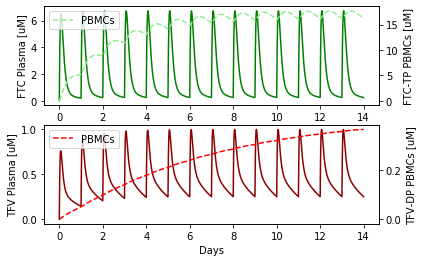

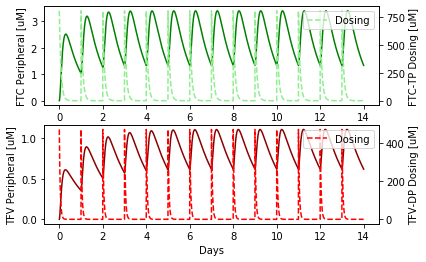

In [59]:
#First, I extract the compartment of interest. In this case, we look at the cellular and plasma concentration (cellular and central compartment)
C1_ftc = np.array(c_ftc[:,0,0,0])
C3_ftc = np.array(c_ftc[:,0,0,2])
C2_ftc = np.array(c_ftc[:,0,0,1])
D_ftc = np.array(c_ftc[:,0,0,3])

#checking probability of above LLOQ
print(len(C1_ftc))
print(sum(i>0.035 for i in C1_ftc))
print(sum(i>0.035 for i in C1_ftc)/len(C1_ftc))

C1_tdf = np.array(c_tdf[:,0,0,0])
C3_tdf = np.array(c_tdf[:,0,0,2])
C2_tdf = np.array(c_tdf[:,0,0,1])
D_tdf = np.array(c_tdf[:,0,0,3])

print(C3_tdf)
# compartments: c1 is cellular central, peripheral, cellular and dosing compartment


fig, (ax1,ax3) = plt.subplots(2)

ax1.plot([t/50/24 for t in range(len(C1_ftc))], C1_ftc, color = 'green', label = "Plasma")
ax1.set_ylabel('FTC Plasma [uM]')
ax2 = ax1.twinx()
ax2.plot([t/50/24 for t in range(len(C3_ftc))], C3_ftc, linestyle = '--',color = 'lightgreen', label = "PBMCs")
ax2.set_ylabel('FTC-TP PBMCs [uM]')
plt.legend()

ax3.plot([t/50/24 for t in range(len(C1_tdf))], C1_tdf,color = 'darkred', label = "Plasma")
ax3.set_ylabel('TFV Plasma [uM]')
ax4 = ax3.twinx()
ax4.plot([t/50/24 for t in range(len(C3_tdf))], C3_tdf, linestyle = '--',color = 'red', label = "PBMCs")
ax4.set_ylabel('TFV-DP PBMCs [uM]')
ax3.set_xlabel('Days')
plt.legend()
plt.show()

fig, (ax1,ax3) = plt.subplots(2)

ax1.plot([t/50/24 for t in range(len(C2_ftc))], C2_ftc, color = 'green', label = "Peripheral")
ax1.set_ylabel('FTC Peripheral [uM]')
ax2 = ax1.twinx()
ax2.plot([t/50/24 for t in range(len(D_ftc))], D_ftc, linestyle = '--',color = 'lightgreen', label = "Dosing")
ax2.set_ylabel('FTC-TP Dosing [uM]')
plt.legend()

ax3.plot([t/50/24 for t in range(len(C2_tdf))], C2_tdf,color = 'darkred', label = "Peripheral")
ax3.set_ylabel('TFV Peripheral [uM]')
ax4 = ax3.twinx()
ax4.plot([t/50/24 for t in range(len(D_tdf))], D_tdf, linestyle = '--',color = 'red', label = "Dosing")
ax4.set_ylabel('TFV-DP Dosing [uM]')
ax3.set_xlabel('Days')
plt.legend()
plt.show()


### b) change the file of MMOA for Truvada


A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 
PD file changed
16801
16800
0.9999404797333492
[0.00000000e+00 0.00000000e+00 1.35473561e-05 ... 3.66611564e-01
 3.66613051e-01 3.66614529e-01]


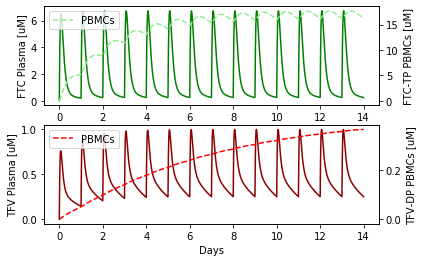

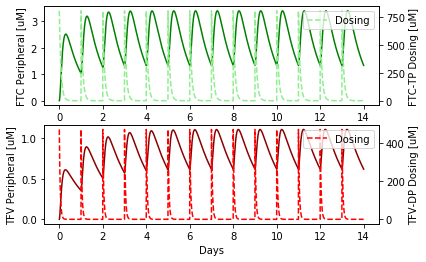

In [60]:
r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)
e = EfficacyPredictor()
e.add_regimen(r)
e.add_regimen(r1)
# change the file which contains the MMOA matrix, default is modMMOA_FTC_TDF_zero_extended.csv
e.set_pd_file('Data/comb_output_ColChen.csv')
# then run the computation normally
e.compute_extinction_probability()

c_tdf = e.get_concentration('TDF')
c_ftc = e.get_concentration('FTC')

c_tdf.shape, c_ftc.shape


C1_ftc = np.array(c_ftc[:,0,0,0])
C3_ftc = np.array(c_ftc[:,0,0,2])
C2_ftc = np.array(c_ftc[:,0,0,1])
D_ftc = np.array(c_ftc[:,0,0,3])

#checking probability of above LLOQ
print(len(C1_ftc))
print(sum(i>0.035 for i in C1_ftc))
print(sum(i>0.035 for i in C1_ftc)/len(C1_ftc))

C1_tdf = np.array(c_tdf[:,0,0,0])
C3_tdf = np.array(c_tdf[:,0,0,2])
C2_tdf = np.array(c_tdf[:,0,0,1])
D_tdf = np.array(c_tdf[:,0,0,3])

print(C3_tdf)
# compartments: c1 is cellular central, peripheral, cellular and dosing compartment


fig, (ax1,ax3) = plt.subplots(2)

ax1.plot([t/50/24 for t in range(len(C1_ftc))], C1_ftc, color = 'green', label = "Plasma")
ax1.set_ylabel('FTC Plasma [uM]')
ax2 = ax1.twinx()
ax2.plot([t/50/24 for t in range(len(C3_ftc))], C3_ftc, linestyle = '--',color = 'lightgreen', label = "PBMCs")
ax2.set_ylabel('FTC-TP PBMCs [uM]')
plt.legend()

ax3.plot([t/50/24 for t in range(len(C1_tdf))], C1_tdf,color = 'darkred', label = "Plasma")
ax3.set_ylabel('TFV Plasma [uM]')
ax4 = ax3.twinx()
ax4.plot([t/50/24 for t in range(len(C3_tdf))], C3_tdf, linestyle = '--',color = 'red', label = "PBMCs")
ax4.set_ylabel('TFV-DP PBMCs [uM]')
ax3.set_xlabel('Days')
plt.legend()
plt.show()

fig, (ax1,ax3) = plt.subplots(2)

ax1.plot([t/50/24 for t in range(len(C2_ftc))], C2_ftc, color = 'green', label = "Peripheral")
ax1.set_ylabel('FTC Peripheral [uM]')
ax2 = ax1.twinx()
ax2.plot([t/50/24 for t in range(len(D_ftc))], D_ftc, linestyle = '--',color = 'lightgreen', label = "Dosing")
ax2.set_ylabel('FTC-TP Dosing [uM]')
plt.legend()

ax3.plot([t/50/24 for t in range(len(C2_tdf))], C2_tdf,color = 'darkred', label = "Peripheral")
ax3.set_ylabel('TFV Peripheral [uM]')
ax4 = ax3.twinx()
ax4.plot([t/50/24 for t in range(len(D_tdf))], D_tdf, linestyle = '--',color = 'red', label = "Dosing")
ax4.set_ylabel('TFV-DP Dosing [uM]')
ax3.set_xlabel('Days')
plt.legend()
plt.show()


### c) change the local-to-PBMC level 


In [16]:
r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)
e2 = EfficacyPredictor()
e2.add_regimen(r)
e2.add_regimen(r1)
# to change the concentration according to the local-to-PBMC ratio, we have to: 
# 1. compute the concentration
# 2. set local-to-PBMC ratio for the concentration of certain drug  
# 3. compute the extinction probability /efficacy
e2.compute_concentration()
#here, we substitute with the proportion of interest (Colo-rectal tissue)
#this will affect the computation of the efficacy. If you want to visualize the change in PK trajectory
# simply multiply the cellular concentration vector by the corresponding factor
rai_ftc_factor = 0.036584415522861
rai_tdf_factor = 2.92370504001375
e2.set_concentration_proportion('FTC', rai_ftc_factor) 
e2.set_concentration_proportion('TDF', rai_tdf_factor) 
e2.compute_extinction_probability()


A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 


In [17]:
c_tdf_local = e2.get_concentration('TDF')
c_ftc_local = e2.get_concentration('FTC')

c_tdf_local.shape, c_ftc_local.shape

(torch.Size([16801, 1, 1, 4]), torch.Size([16801, 1, 1, 4]))

In [29]:
C3_ftc_local = np.array(c_ftc_local[:,0,0,2])*rai_ftc_factor
C3_tdf_local = np.array(c_tdf_local[:,0,0,2])*rai_tdf_factor
C3_tdf_local.shape, C3_ftc_local.shape

print(C3_ftc_local)


[0.00000000e+00 0.00000000e+00 7.44445525e-05 ... 5.90805153e-01
 5.90688469e-01 5.90571734e-01]


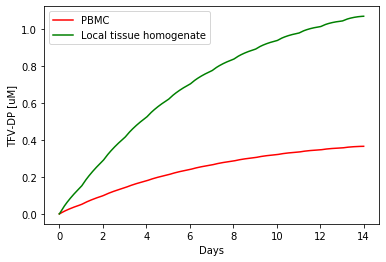

[0.00000000e+00 0.00000000e+00 1.35473561e-05 ... 3.66611564e-01
 3.66613051e-01 3.66614529e-01]
[0.00000000e+00 0.00000000e+00 3.96084734e-05 ... 1.07186408e+00
 1.07186843e+00 1.07187275e+00]


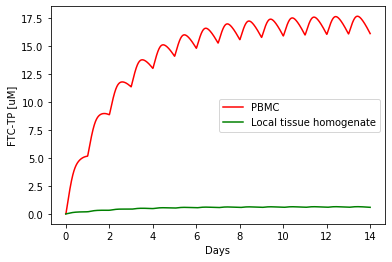

In [35]:
plt.plot([t/50/24 for t in range(len(C3_tdf))], C3_tdf,color = 'red', label = "PBMC")
plt.plot([t/50/24 for t in range(len(C3_tdf_local))], C3_tdf_local, color = 'green', label = "Local tissue homogenate")
plt.legend()
plt.xlabel("Days")
plt.ylabel('TFV-DP [uM]')

plt.show()
print(C3_tdf)
print(C3_tdf_local)

plt.plot([t/50/24 for t in range(len(C3_ftc))], C3_ftc, color = 'red', label = "PBMC")
plt.plot([t/50/24 for t in range(len(C3_ftc_local))], C3_ftc_local, color = 'green', label = "Local tissue homogenate")
plt.legend()
plt.xlabel("Days")
plt.ylabel("FTC-TP [uM]")
plt.show()

We can now compute the efficacy by considering the 100% RAI exposure, and compare the result with the reference concentration matrix (PBMCs, in blue) vs the local PK trajectory (red)

(16801, 1, 1, 3, 1)


(0, 1.1)

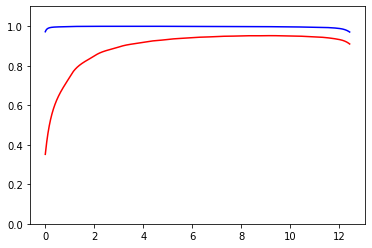

In [39]:
pe = e.get_extinction_probability()
indicator = [0,0,0,0,1] 
phi_rai_f = process_pe_to_phi(indicator, [pe.numpy()])

remove_tail = (days*24*50)-(38*50) #removing the last 38 hours from the trajectory
plt.plot([t/24/50 for t in range(remove_tail)], phi_rai[:remove_tail,:,0,0,0], color = 'blue')
plt.plot([t/24/50 for t in range(remove_tail)], phi_rai_f[:remove_tail,:,0,0,0], color = 'red')
plt.ylim(0,1.1)


You can now set-up your simulation and manually implement your hypothesis:

adherence pattern, pharmacokinetic matrix, dNTP concentrations and route of exposure.

The example below refers to: two doses per week, colo-rectal tissue as local PK, colo-rectal dNTP and 100% RAI.


In [40]:
# specify simulation horizon
weeks = 10
days = weeks*7
t0, t1 = 0, days*24

# Adherence
weekly_adherence = [1,0,0,1,0,0,0]
p = np.array([weekly_adherence*weeks])

# simulation set-up
r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)
e = EfficacyPredictor()
e.add_regimen(r)
e.add_regimen(r1)

# local PK 
rai_ftc_factor = 0.036584415522861
rai_tdf_factor = 2.92370504001375
e.set_concentration_proportion('FTC', rai_ftc_factor) 
e.set_concentration_proportion('TDF', rai_tdf_factor)

# local dNTP
e.set_pd_file('Data/comb_output_ColChen.csv')

# compute the extinction probability
e.compute_extinction_probability()
pe = e.get_extinction_probability()

# compute the prophylactic efficacy for the selected exposure route:
# 100% Receptive Anal Intercourse 
indicator = [0,0,0,0,1] 
phi_rai_f = process_pe_to_phi(indicator, [pe.numpy()])



A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 
PD file changed
(84001, 1, 1, 3, 1)


(0, 1.1)

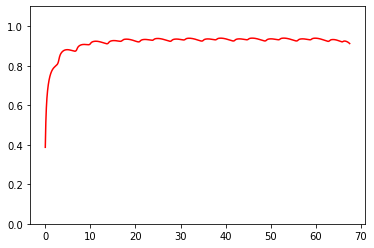

In [41]:
remove_tail = (days*24*50)-(60*50) #removing the last 60 hours from the trajectory
plt.plot([t/24/50 for t in range(remove_tail)], phi_rai_f[:remove_tail,:,0,0,0], color = 'red')
plt.ylim(0,1.1)

## Example with dosing csv

In [25]:
dose = 7
adh = pd.read_csv('dosing.csv', index_col=0).iloc[[7 - dose]].values

t0, t1 = 0, 90*24

r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=adh)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=adh)
e = EfficacyPredictor()
e.add_regimen(r)
e.add_regimen(r1)

# get instinction probability
e.compute_extinction_probability()
pe = e.get_extinction_probability()
print(pe.shape)

A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 
torch.Size([108001, 1, 1, 3, 1])


In [26]:
# get infection efficacy
e.compute_infection_probability()
pi = e.get_infection_probability()
print(pi.shape)

PGS class changed
torch.Size([108001, 1, 1, 3, 1])


In [27]:
# get efficacy 
e.compute_efficacy()
phi = e.get_efficacy()
print(phi.shape)

torch.Size([108001, 1, 1])


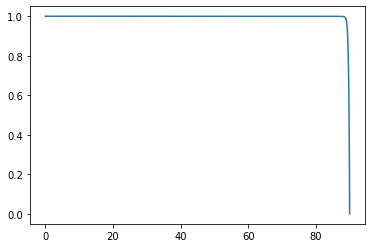

In [ ]:
indicator = [0,0,0,0,1] # 100% receptive anal intercourse
phi_rai_f = process_pe_to_phi(indicator, [pe.numpy()])